-2.220446049250313e-16
(array([[-0.45219475, -0.3887402 , -0.05886363,  0.84756133, -0.62393669],
       [-0.28954423, -0.37772923,  0.19213062,  0.51499428, -1.29719079],
       [ 1.37418908,  1.34684233, -0.45866949,  2.52551649,  0.32776405],
       [-0.9195559 ,  2.6176982 ,  0.43173556, -0.77117473, -0.26561346],
       [-1.71933374, -0.40539216, -1.39791545, -0.33346672, -0.56791718]]), array([[0.03829566, 3.07126695, 1.19287086, 1.37074856, 3.52938667],
       [6.12092585, 2.48539951, 3.86358634, 2.64320054, 1.39682359],
       [4.46927779, 2.5960609 , 5.44402571, 1.51963085, 2.39324949],
       [4.8140235 , 4.8494376 , 3.2472872 , 5.64526594, 1.00860401],
       [2.15064703, 4.24355919, 0.60253841, 4.87039056, 1.60316697]]))
ini= 22.365803772712518
final= 10.950204693457287


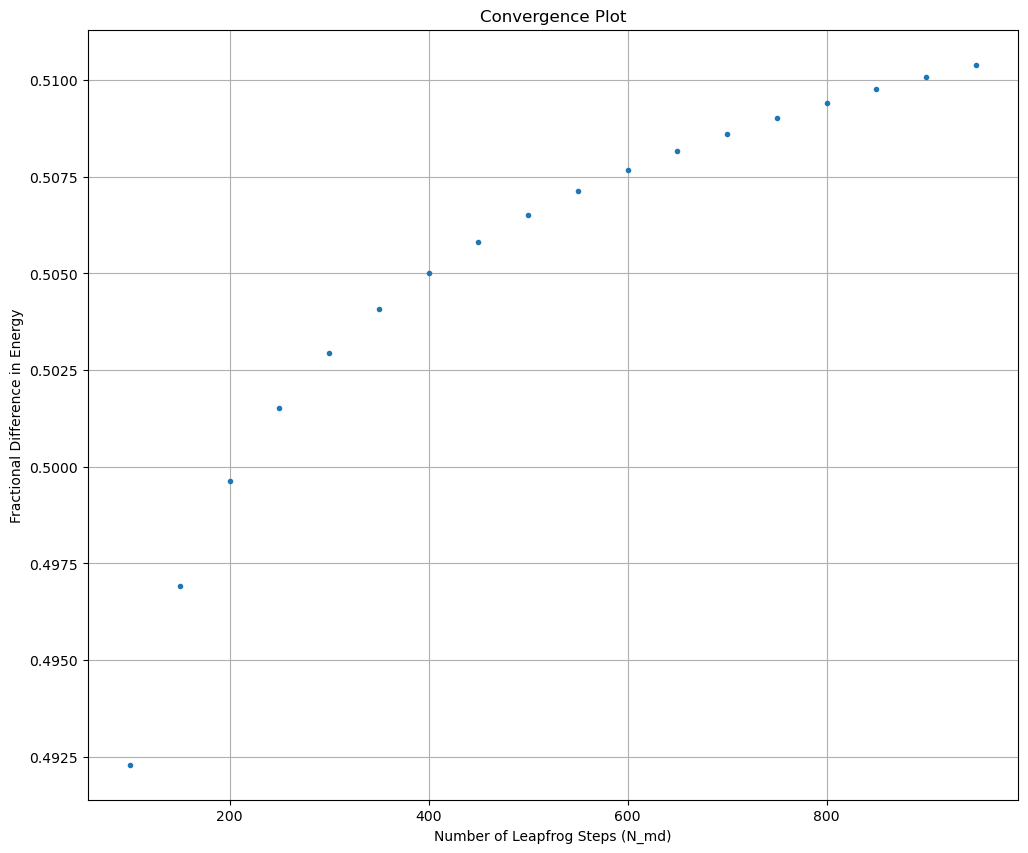

In [1]:

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import math
# Defining some variables

N = 5
L =  np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)]) # ask
N_md = 4
p_0 = np.random.normal(size=(N,N))
J=1
beta=1


# Defining the Hamiltonian XY model
def Hamiltonian2D(J, L):
    Hamiltonian2D = -J*np.sum(np.cos(L[::] - np.roll(L, 1, axis=0))
                              +np.cos(L[::] - np.roll(L, -1, axis=0))
                              +np.cos(L[::] - np.roll(L, 1, axis=1))
                              +np.cos(L[::] - np.roll(L, -1, axis=1)))
    return Hamiltonian2D/2


# Defining the artifical Hamiltonian XY model

def Hamiltonian2D_art(J, L, P, beta):
    n = np.shape(L)[0]
    Hamiltonian2D_art = sum(sum(P**2))/2 + beta*Hamiltonian2D(J, L)
    return Hamiltonian2D_art


# Defining the equations of motion

def P_dot_i_2D(J, L,beta):

    P_dot_i_2D = -J*np.sum(np.sin(L[::] - np.roll(L, 1, axis=0))
                              +np.sin(L[::] - np.roll(L, -1, axis=0))
                              +np.sin(L[::] - np.roll(L, 1, axis=1))
                              +np.sin(L[::] - np.roll(L, -1, axis=1)))
    return P_dot_i_2D*beta


def phi_dot(P):   # confirm
    return P
            
print(P_dot_i_2D(1, L,beta))

# Leapfrog integrator

def leapfrog_2D(N_md, p_0,J, L, beta): 
    epsilon = 1/N_md
    p = p_0
    L_new = L
    L_new += phi_dot(p)*epsilon/2
    L_new = abs(L_new%(2*np.pi))
    for i in range(N_md-1):
        p += P_dot_i_2D(J, L,beta)*epsilon
        L_new += phi_dot(p)*epsilon
        L_new = abs(L_new%(2*np.pi))
    
    p +=  P_dot_i_2D(J, L,beta)*epsilon/2
    L_new -= phi_dot(p)*epsilon/2
    L_new = abs(L_new%(2*np.pi))
    return p, L_new

print(leapfrog_2D(N_md,p_0, J, L,beta))


diff = []
range_1 =[10*i for i in range(10,100,5)]
p_0 = np.random.normal(size=(N,N))
for N_md in range_1:
   
    arr = leapfrog_2D(N_md, p_0, J,L,beta)
    p_f = arr[0]          # We need final values of p_f and phi_f to calculate H_f
    Lat_ev = arr[1]
    H_f = Hamiltonian2D_art(J, Lat_ev, p_f, beta)
    H_0 = Hamiltonian2D_art(J, L, p_0, beta)

# The following is the quantity we want on y-axis
    diff.append(abs((H_f-H_0)/H_0)) 
    

print("ini=",H_0)
print("final=",H_f)
ini= 10662.036426656732
final= 10671.118479150738
plt.figure(figsize=(12,10))
plt.xlabel('Number of Leapfrog Steps (N_md)')
plt.ylabel('Fractional Difference in Energy')
plt.title('Convergence Plot')
plt.grid()
plt.plot(range_1, diff,'.')
plt.show()



In [2]:

def markov_chain(L_i,N_cfg,N_md,beta,J,elem_num):
    chain = []
    chain.append(L_i)
    for i in range(N_cfg):
        # Random sample
        p_hmc = np.random.normal(size=(N,N))
        new = leapfrog_2D(N_md,p_hmc, J, chain[-1],beta) # Integrating leapfrog algorithm
        prob = np.exp(Hamiltonian2D_art(J,chain[-1],p_hmc,beta)-Hamiltonian2D_art(J,new[1],new[0],beta))
#  Given probability distribution function defined above
        if prob > np.random.uniform(0,1):   # Accept/reject
            chain.append(new[1])  
        else:                           
            chain.append(chain[-1]) 
    return chain[-elem_num:]


def variables(L_i, N_cfg, N_md, J, beta,elem_num):
    chain = markov_chain(L_i,N_cfg,N_md,beta,J,elem_num)
    m = 0.0
    E = 0.0
    for i in chain:
        m += np.sum(i)
        E += Hamiltonian2D(J,i)  
    m = m/N*N
    E = E/N*N

        
    return m,E



Text(0.5, 1.0, 'm as a f(T) for N = 5')

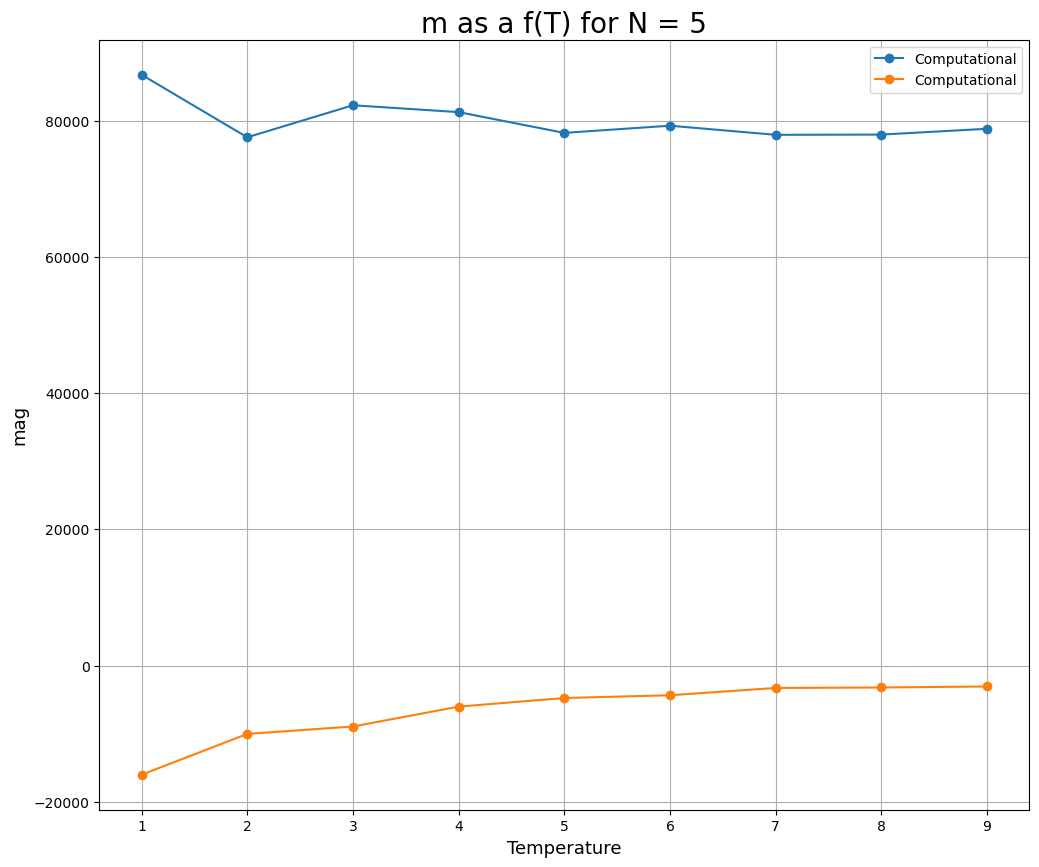

In [3]:
N_cfg = 1000
beta_range = np.arange(1,10,1) 
elem_num = 50
# beta = 1 / kb * T
L_i =  np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)]) #not sure, should be the random 
# sample but will we define it like this? if we do this then it will be the same as L but shouldnt be same right?

mag_5 = [variables(L_i, N_cfg, N_md, J, 1/i, elem_num) for i in beta_range]

plt.figure(figsize = (12,10))
plt.plot(beta_range, mag_5, 'o-',label="Computational")
plt.grid()
plt.xlabel("Temperature", fontsize = 13)
plt.ylabel("mag", fontsize = 13)
plt.legend()
plt.title("m as a f(T) for N = 5", fontsize = 20 )